In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_51462/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

DEBUG_PRINT = True

backend = provider.get_backend('ibm_sherbrooke') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = 1

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7fd1e6a23520>
backend_name
ibm_sherbrooke
backend_version
1.4.45
n_qubits
127
basis_gates
['id', 'rz', 'sx', 'x', 'ecr', 'reset']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112

## Acquisition Scan Experiment with Large Latency

In [3]:
from exp_classes.device_charecterisation import StandardAcqScanExp
from utils import get_dt_from

acq_latency_dt = get_dt_from(600 * ns, dt)

acq_latency_exp = StandardAcqScanExp(
    qubit=qubit,
    backend=backend,
    acq_latency_dt=acq_latency_dt,
    acq_start_dt=get_dt_from(0. * ns, dt),
    acq_end_dt=measure_pulse.duration + measure_delay.duration + acq_latency_dt,
    num_acq_exp=141,
    acq_meas_dur_dt=get_dt_from(16. * ns, dt),
)

acq_latency_jobs, acq_latency_info = acq_latency_exp.get_jobs()

acq_latency_info

{'Total Experiment Size': 282,
 'Acquisition Latency (ns)': 601.0,
 'Acquisition Start Delay (ns)': 0.0,
 'Acquisition End Delay (ns)': 1845.0,
 'Acquisition Duration (ns)': 18.0}

In [4]:
acq_ss_exp = StandardAcqScanExp(
    qubit=qubit,
    backend=backend,
    acq_latency_dt=acq_latency_dt,
    acq_start_dt=get_dt_from(0. * ns, dt),
    acq_end_dt=2 * measure_pulse.duration + measure_delay.duration + acq_latency_dt,
    num_acq_exp=141,
    acq_meas_dur_dt=get_dt_from(16. * ns, dt),
    meas_duration_dt=2 * measure_pulse.duration,
)

acq_ss_jobs, acq_ss_info = acq_ss_exp.get_jobs()

acq_ss_info

{'Total Experiment Size': 282,
 'Acquisition Latency (ns)': 601.0,
 'Acquisition Start Delay (ns)': 0.0,
 'Acquisition End Delay (ns)': 2628.0,
 'Acquisition Duration (ns)': 18.0}

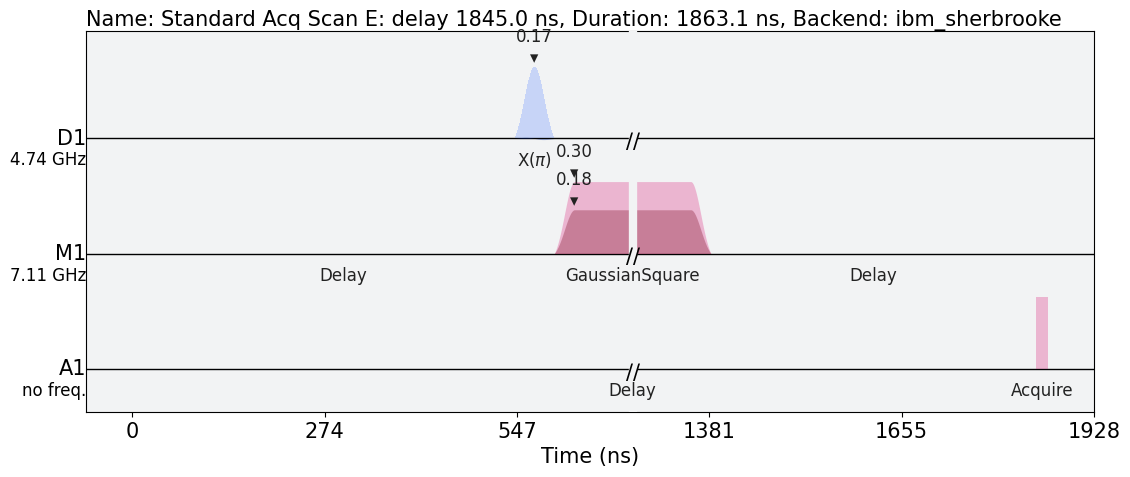

In [5]:
acq_latency_jobs[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

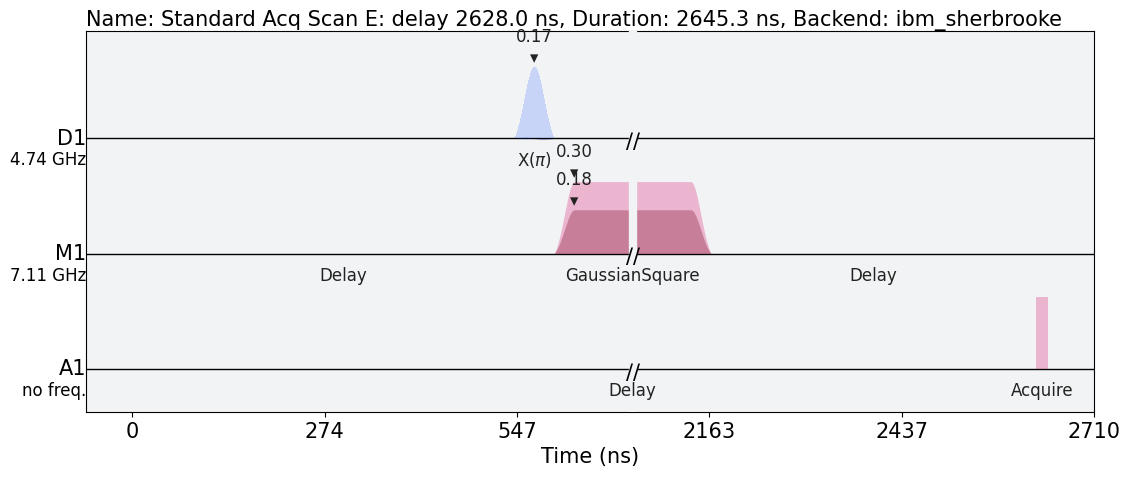

In [6]:
acq_ss_jobs[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [7]:
from utils import acquisition_checker

num_shots = 8192
rep_delay = 499. * us

acquisition_checker(acq_latency_jobs, backend)
acquisition_checker(acq_ss_jobs, backend)

print(len(acq_latency_jobs))
print(len(acq_ss_jobs))

282
282


In [13]:
# Running acq_latency_jobs, acq_ss_jobs

job_experiment = backend.run(acq_ss_jobs, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

Job Status: job is queued

KeyboardInterrupt: 

In [8]:
job_1 = provider.backend.retrieve_job(job_id='crwsfvzdbt40008jz5sg') # Queue
job_2 = provider.backend.retrieve_job(job_id='crwsfyzx484g008fdxgg') # Queue

In [9]:
from utils import get_results_arr

results_1 = get_results_arr(job_1.result(), qubit)
results_2 = get_results_arr(job_2.result(), qubit)

## Latency Experiment Results

In [10]:
from utils import get_fidelity

acq_latency_g, acq_latency_e = results_1.reshape(2, -1, num_shots)
latency_fidelity, sep_latency_fidelity = get_fidelity(acq_latency_g, acq_latency_e)

acq_ss_g, acq_ss_e = results_2.reshape(2, -1, num_shots)
ss_fidelity, sep_ss_fidelity = get_fidelity(acq_ss_g, acq_ss_e)

0.9921875


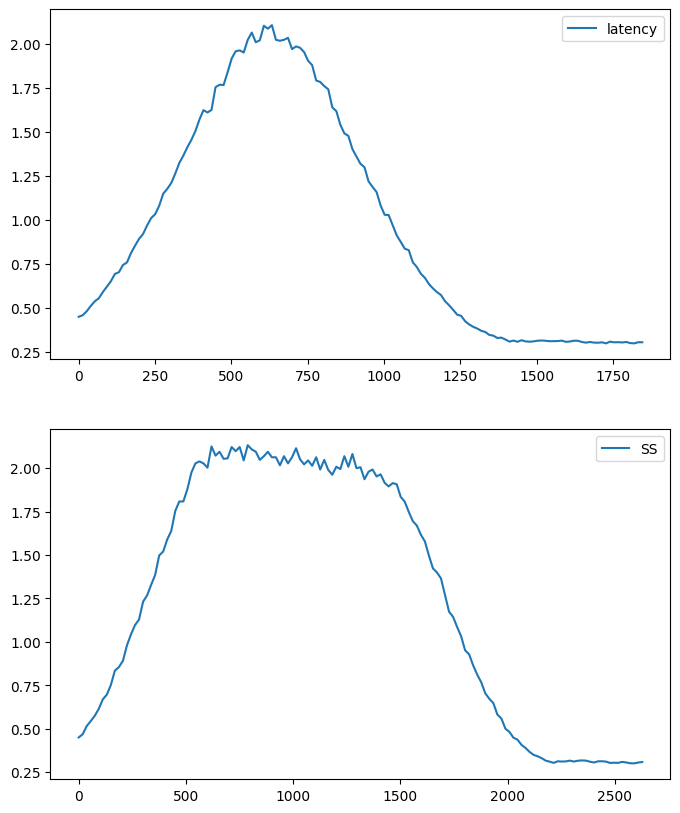

In [11]:
latency_linspace = acq_latency_exp.acq_delay_linspace_ns / ns
ss_linspace = acq_ss_exp.acq_delay_linspace_ns / ns

fig, ax = plt.subplots(2, figsize=(8.0, 10.0))

print(np.max(latency_fidelity))

latency_pF = -np.log10(1. - latency_fidelity)
ss_pF = -np.log10(1. - ss_fidelity)

ax[0].plot(latency_linspace, latency_pF, label='latency')
ax[0].legend()

ax[1].plot(ss_linspace, ss_pF, label='SS')
ax[1].legend()

plt.show()

In [12]:
import copy

results_1 = get_results_arr(job_1.result(), qubit)
results_1_arr = copy.deepcopy(results_1)

results_2 = get_results_arr(job_2.result(), qubit)
results_2_arr = copy.deepcopy(results_2)

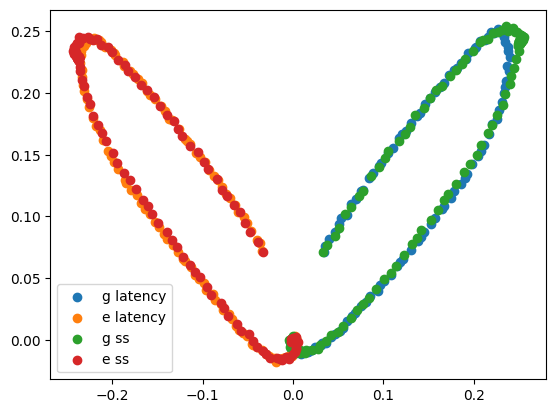

In [13]:
from utils import get_corrected_means

raw_res_latency_g, raw_res_latency_e = results_1_arr.reshape(2, -1, num_shots)
raw_res_ss_g, raw_res_ss_e = results_2_arr.reshape(2, -1, num_shots)

means_latency_g, means_latency_e = get_corrected_means(raw_res_latency_g, raw_res_latency_e)
means_ss_g, means_ss_e = get_corrected_means(raw_res_ss_g, raw_res_ss_e)

plt.scatter(means_latency_g.real, means_latency_g.imag, label='g latency')
plt.scatter(means_latency_e.real, means_latency_e.imag, label='e latency')
plt.scatter(means_ss_g.real, means_ss_g.imag, label='g ss')
plt.scatter(means_ss_e.real, means_ss_e.imag, label='e ss')
plt.legend()
plt.show()